## Imports

In [1]:
# The code used for the construction and evaluation of the MLP model was adapeted from code seen in the following 
# online course: [https://www.linkedin.com/learning/neural-networks-and-convolutional-neural-networks-essential-training]
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import time


from numpy import genfromtxt
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
from mpl_toolkits.mplot3d import Axes3D


from sklearn.linear_model import LogisticRegression
#----------------------------------------------Neural Net Imports
from keras.datasets import mnist
from keras.preprocessing.image import load_img, array_to_img
from keras.utils.np_utils import to_categorical

# Linear stack of NN layers
from keras.models import Sequential

# Ensure Fully connected layer 
from keras.layers import Dense
#----------------------------------------------------------------

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import cross_val_predict

from sklearn.model_selection import StratifiedKFold

import ROCModule as roc 


num_pixels = 28
%matplotlib inline

Using TensorFlow backend.


In [2]:
# Importing training  data from CSV files
x_train = genfromtxt('Data/Training/x_train_gr_smpl.csv', delimiter=',', skip_header =1)
y_train = genfromtxt('Data/Training/y_train_smpl.csv', delimiter=',', skip_header =1 )

In [3]:
# Importing testing data from CSV files
x_test = genfromtxt('Data/Testing/x_test_gr_smpl.csv', delimiter=',', skip_header =1)
y_test = genfromtxt('Data/Testing/y_test_smpl.csv', delimiter=',', skip_header =1 )

In [4]:
# Check data has been imported correctly 
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(12660, 2304)
(12660,)
(4170, 2304)
(4170,)


## Preprocessing

In [5]:
# Combinging data with labels
y_train = y_train.reshape(12660,1)
train_data_combined = np.append(x_train, y_train, axis=1)

y_test = y_test.reshape(4170,1)
test_data_combined = np.append(x_test, y_test, axis=1)


In [6]:
# Randomises row order in a reproducable way 
np.random.seed(0)
np.random.shuffle(train_data_combined)
np.random.shuffle(test_data_combined)

In [7]:
# Split data and lables that have undergone the same randomization process
x_train = train_data_combined[:,:-1]
y_train = train_data_combined[:, [-1]].reshape(12660,)

x_test = test_data_combined[:,:-1]
y_test = test_data_combined[:, [-1]].reshape(4170,)

In [8]:
# Normalisation of pixels
x_train = x_train.astype('float')/255
x_test  = x_test.astype('float')/255

In [9]:
#  Reducing the number of attributes using opencv's reduce functionality as shown in the second python Lecture
#  As seen in python lectures: https://vision.hw.ac.uk/webapps/blackboard/content/listContent.jsp?course_id=_94419_1&content_id=_3391865_1

x_train = np.apply_along_axis(
        func1d=lambda img: cv2.resize(img.reshape((48,48)), (num_pixels,num_pixels)),
        axis =1, arr = x_train).reshape((-1,num_pixels*num_pixels))

x_test  = np.apply_along_axis(
        func1d=lambda img: cv2.resize(img.reshape((48,48)), (num_pixels,num_pixels)),
        axis =1, arr = x_test).reshape((-1,num_pixels*num_pixels))

In [10]:
x_train.shape

(12660, 784)

In [11]:
#  Creating 10 bins for output - Converting Data into Catergorical format compatible with MLP output layer 
y_train_Cat = to_categorical(y_train,10)
y_test_Cat= to_categorical(y_test,10)



# Neural Networks - MLP Methods

In [12]:
# Method to construct MLP model - model define in method body  
def construct_new_model():
    
    # Specifying a sequential modle 
    model = Sequential()
    
    # Dense Adds fully connected nodes in each layer 
    # Input layer is the number of pixels & their values 
    
    # Layer 1
    model.add(Dense(512, activation = 'relu',input_shape=(784,)))

    # Layer 2
    model.add(Dense(512, activation = 'relu'))
    
    # Output Layer
    model.add(Dense(10, activation = 'softmax'))
    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics = ['accuracy'])
    
    return model

    

In [13]:
# Ref:[https://www.youtube.com/watch?v=gJo0uNL-5Qw] - Used to make code more concise 
def get_score(model, x_train, x_test, y_train, y_test):
    model.fit(x_train, y_train, epochs = 20, validation_data = (x_test, y_test))
    return model.evaluate(x_test, y_test)

In [14]:
# Modification of above method
def get_network_output(model, x_train, x_test, y_train, y_test):
    x = model.fit(x_train, y_train, epochs = 20, validation_data = (x_test, y_test))
    return x

In [15]:
# Modification of above method
def get_prediction(model, x_train, x_test, y_train, y_test):
    x = model.fit(x_train, y_train, epochs = 20)
    train_acc = x.history['accuracy'][-1]
    return (model.predict_classes(x_test), train_acc)

# 10-fold cross valiadation

In [16]:
# Uniformly separates classes in folds: See video @12:00 https://www.youtube.com/watch?v=gJo0uNL-5Qw
# Proportion of classes is same accross all folds
skf = StratifiedKFold(n_splits=10, random_state=None, shuffle=False)

In [17]:
# Empty list to to which we wil append each folds acccuaracy 
ScoreArray = []
Models = []

In [18]:
# https://stackoverflow.com/questions/48508036/sklearn-stratifiedkfold-valueerror-supported-target-types-are-binary-mul
# Training and testing a new Base MLP model on each fold
for i, (train_index, test_index) in enumerate(skf.split(x_train, y_train_Cat.argmax(1))):
    x_train_kf, x_test_kf = x_train[train_index], x_train[test_index]
    y_train_kf, y_test_kf = y_train_Cat[train_index], y_train_Cat[test_index]
    ScoreArray.append(get_score(construct_new_model(), x_train_kf, x_test_kf, y_train_kf, y_test_kf))


Train on 11394 samples, validate on 1266 samples
Epoch 1/20
11394/11394 [==============================] - 4s 311us/step - loss: 0.8787 - accuracy: 0.7199 - val_loss: 0.4275 - val_accuracy: 0.8728
Epoch 2/20
11394/11394 [==============================] - 3s 293us/step - loss: 0.3929 - accuracy: 0.8708 - val_loss: 0.2732 - val_accuracy: 0.9250
Epoch 3/20
11394/11394 [==============================] - 3s 297us/step - loss: 0.3193 - accuracy: 0.8992 - val_loss: 0.2668 - val_accuracy: 0.9052
Epoch 4/20
11394/11394 [==============================] - 3s 294us/step - loss: 0.2628 - accuracy: 0.9128 - val_loss: 0.2187 - val_accuracy: 0.9068
Epoch 5/20
11394/11394 [==============================] - 3s 295us/step - loss: 0.2067 - accuracy: 0.9319 - val_loss: 0.2150 - val_accuracy: 0.9392
Epoch 6/20
11394/11394 [==============================] - 3s 295us/step - loss: 0.1806 - accuracy: 0.9384 - val_loss: 0.2126 - val_accuracy: 0.9289
Epoch 7/20
11394/11394 [==============================] - 3s 29

11394/11394 [==============================] - 9s 787us/step - loss: 0.1724 - accuracy: 0.9433 - val_loss: 0.2018 - val_accuracy: 0.9273
Epoch 8/20
11394/11394 [==============================] - 8s 730us/step - loss: 0.1356 - accuracy: 0.9568 - val_loss: 0.2656 - val_accuracy: 0.9044
Epoch 9/20
11394/11394 [==============================] - 10s 899us/step - loss: 0.1818 - accuracy: 0.9461 - val_loss: 0.1222 - val_accuracy: 0.9637
Epoch 10/20
11394/11394 [==============================] - 9s 755us/step - loss: 0.1100 - accuracy: 0.9637 - val_loss: 0.0882 - val_accuracy: 0.9779
Epoch 11/20
11394/11394 [==============================] - 7s 607us/step - loss: 0.0958 - accuracy: 0.9688 - val_loss: 0.1617 - val_accuracy: 0.9494
Epoch 12/20
11394/11394 [==============================] - 10s 908us/step - loss: 0.1243 - accuracy: 0.9573 - val_loss: 0.3576 - val_accuracy: 0.8926
Epoch 13/20
11394/11394 [==============================] - 9s 795us/step - loss: 0.0861 - accuracy: 0.9708 - val_loss:

1266/1266 [==============================] - 0s 158us/step
Train on 11394 samples, validate on 1266 samples
Epoch 1/20
11394/11394 [==============================] - 7s 623us/step - loss: 0.8879 - accuracy: 0.7184 - val_loss: 0.4302 - val_accuracy: 0.8681
Epoch 2/20
11394/11394 [==============================] - 8s 711us/step - loss: 0.3812 - accuracy: 0.8726 - val_loss: 0.4810 - val_accuracy: 0.8412
Epoch 3/20
11394/11394 [==============================] - 9s 819us/step - loss: 0.2996 - accuracy: 0.9019 - val_loss: 0.4303 - val_accuracy: 0.8815
Epoch 4/20
11394/11394 [==============================] - 9s 821us/step - loss: 0.2350 - accuracy: 0.9195 - val_loss: 0.2782 - val_accuracy: 0.9036
Epoch 5/20
11394/11394 [==============================] - 9s 820us/step - loss: 0.1877 - accuracy: 0.9395 - val_loss: 0.1808 - val_accuracy: 0.9494
Epoch 6/20
11394/11394 [==============================] - 9s 765us/step - loss: 0.2063 - accuracy: 0.9353 - val_loss: 0.2659 - val_accuracy: 0.9194
Epoc

In [19]:
# Obtaining the accuaracys of each model
ScoreArray = np.array(ScoreArray)
ScoreArray[:,1:2]

array([[0.98183256],
       [0.91232228],
       [0.97867298],
       [0.97393364],
       [0.98025274],
       [0.97946286],
       [0.97630334],
       [0.95102686],
       [0.94312799],
       [0.96840441]])

In [20]:
# Average accuracy across the 10 models
print(np.mean(ScoreArray[:,1:2]))

0.9645339667797088


# BASE Model on Given Data

In [21]:
# Create a new base model
Base_Model = construct_new_model()

In [22]:
# Train and test the model
pred, train_acc = get_prediction(Base_Model, x_train, x_test, y_train_Cat, y_test_Cat)

Epoch 1/20
12660/12660 [==============================] - 6s 454us/step - loss: 0.8472 - accuracy: 0.7337
Epoch 2/20
12660/12660 [==============================] - 6s 437us/step - loss: 0.3717 - accuracy: 0.8790
Epoch 3/20
12660/12660 [==============================] - 6s 437us/step - loss: 0.2898 - accuracy: 0.9028
Epoch 4/20
12660/12660 [==============================] - 5s 433us/step - loss: 0.2269 - accuracy: 0.9255
Epoch 5/20
12660/12660 [==============================] - 6s 435us/step - loss: 0.2100 - accuracy: 0.9338
Epoch 6/20
12660/12660 [==============================] - 5s 420us/step - loss: 0.1578 - accuracy: 0.9487
Epoch 7/20
12660/12660 [==============================] - 5s 423us/step - loss: 0.1334 - accuracy: 0.9562
Epoch 8/20
12660/12660 [==============================] - 5s 422us/step - loss: 0.1403 - accuracy: 0.9573
Epoch 9/20
12660/12660 [==============================] - 5s 428us/step - loss: 0.1430 - accuracy: 0.9543
Epoch 10/20
12660/12660 [=====================

In [23]:
# Printing the Classification Report 
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

         0.0       0.81      0.91      0.86       450
         1.0       0.91      0.89      0.90       630
         2.0       0.92      0.73      0.81       150
         3.0       0.99      0.93      0.96       420
         4.0       0.95      0.93      0.94       690
         5.0       0.98      0.99      0.98       720
         6.0       0.92      0.97      0.95       270
         7.0       0.81      1.00      0.90        60
         8.0       0.94      0.95      0.94       690
         9.0       0.99      0.86      0.92        90

    accuracy                           0.93      4170
   macro avg       0.92      0.92      0.92      4170
weighted avg       0.93      0.93      0.93      4170



In [24]:
# get the accuaracy 
test_acc = accuracy_score(y_test, pred)

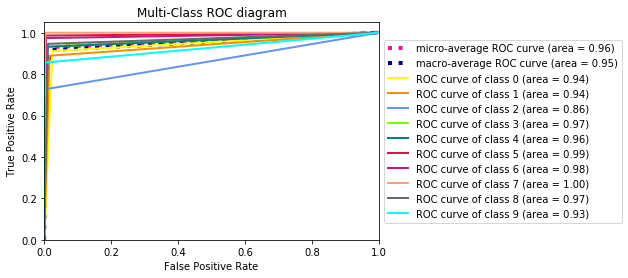

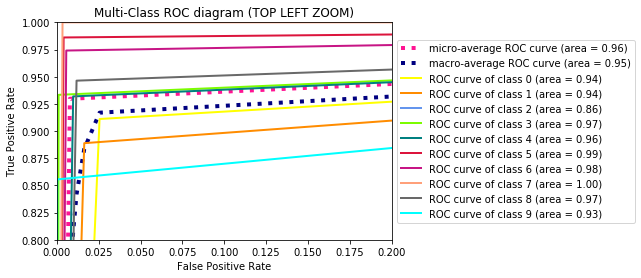

In [25]:
# plot ROC the curve
roc.plotROC(y_test,pred)

In [26]:
print("Test Accuarcy:{}".format(test_acc))
print("Training Accuaracy: {}".format(train_acc))
print("Difference: {}".format(train_acc - test_acc))

Test Accuarcy:0.9297362110311751
Training Accuaracy: 0.9773301482200623
Difference: 0.04759393718888716


# Moving 4000 images from training to test set

In [27]:
# Check data has been imported correctly 
print(x_train.shape)
print(y_train_Cat.shape)
print(x_test.shape)
print(y_test_Cat.shape)

(12660, 784)
(12660, 10)
(4170, 784)
(4170, 10)


In [29]:
x_train_new = x_train[0:8660,:]
y_train_new = y_train_Cat[0:8660,:]

x_temp = x_train[8660:12660,:]
y_temp = y_train_Cat[8660:12660,:]
Y_temp = y_train[8660:12660]


x_test_new = np.concatenate((x_test, x_temp))
y_test_new = np.concatenate((y_test_Cat, y_temp))

labels = np.concatenate((y_test, Y_temp))




In [30]:
Base_Model = construct_new_model()

In [31]:
pred, train_acc = get_prediction(Base_Model, x_train_new, x_test_new, y_train_new, y_test_new)

Epoch 1/20
8660/8660 [==============================] - 4s 459us/step - loss: 0.9792 - accuracy: 0.6915
Epoch 2/20
8660/8660 [==============================] - 4s 434us/step - loss: 0.4547 - accuracy: 0.8486
Epoch 3/20
8660/8660 [==============================] - 4s 439us/step - loss: 0.3573 - accuracy: 0.8842
Epoch 4/20
8660/8660 [==============================] - 4s 482us/step - loss: 0.2520 - accuracy: 0.9185
Epoch 5/20
8660/8660 [==============================] - 4s 477us/step - loss: 0.2233 - accuracy: 0.9263
Epoch 6/20
8660/8660 [==============================] - 4s 471us/step - loss: 0.2339 - accuracy: 0.9261
Epoch 7/20
8660/8660 [==============================] - 4s 429us/step - loss: 0.1508 - accuracy: 0.9501
Epoch 8/20
8660/8660 [==============================] - 4s 428us/step - loss: 0.1543 - accuracy: 0.9502
Epoch 9/20
8660/8660 [==============================] - 4s 459us/step - loss: 0.1692 - accuracy: 0.9473
Epoch 10/20
8660/8660 [==============================] - 4s 480u

In [32]:
# Printing the Classification Report 
print(classification_report(labels, pred))

              precision    recall  f1-score   support

         0.0       0.92      0.89      0.90       910
         1.0       0.92      0.95      0.93      1210
         2.0       0.96      0.81      0.88       292
         3.0       0.99      0.95      0.97       844
         4.0       0.97      0.95      0.96      1342
         5.0       0.96      0.99      0.98      1395
         6.0       0.98      0.95      0.96       506
         7.0       0.74      0.96      0.84       133
         8.0       0.94      0.97      0.96      1345
         9.0       0.99      0.89      0.94       193

    accuracy                           0.95      8170
   macro avg       0.94      0.93      0.93      8170
weighted avg       0.95      0.95      0.95      8170



In [33]:
test_acc = accuracy_score(labels, pred)

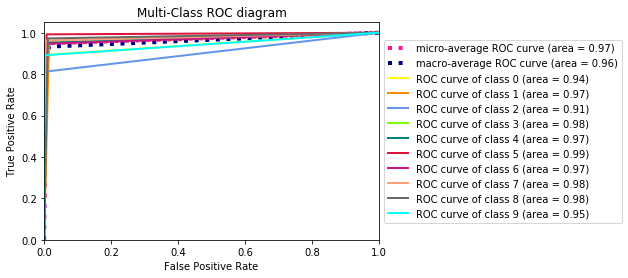

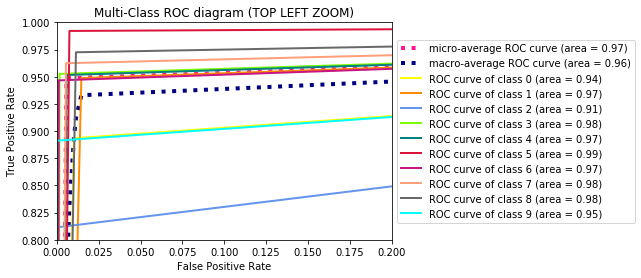

In [34]:
roc.plotROC(labels,pred)

In [35]:
print("Test Accuarcy:{}".format(test_acc))
print("Training Accuaracy: {}".format(train_acc))
print("Difference: {}".format(train_acc - test_acc))

Test Accuarcy:0.9485924112607099
Training Accuaracy: 0.9821016192436218
Difference: 0.033509207982911904


# Moving 9000 images from training to test set


In [36]:
x_train_new = x_train[0:6660,:]
y_train_new = y_train_Cat[0:6660,:]

x_temp = x_train[6660:12660,:]
y_temp = y_train_Cat[6660:12660,:]


Y_temp = y_train[6660:12660]


x_test_new = np.concatenate((x_test, x_temp))
y_test_new = np.concatenate((y_test_Cat, y_temp))


labels = np.concatenate((y_test, Y_temp))


In [37]:
Base_Model = construct_new_model()

In [38]:
pred, train_acc = get_prediction(Base_Model, x_train_new, x_test_new, y_train_new, y_test_new)

Epoch 1/20
6660/6660 [==============================] - 2s 367us/step - loss: 1.0613 - accuracy: 0.6703
Epoch 2/20
6660/6660 [==============================] - 3s 382us/step - loss: 0.5095 - accuracy: 0.8318
Epoch 3/20
6660/6660 [==============================] - 2s 339us/step - loss: 0.3749 - accuracy: 0.8704
Epoch 4/20
6660/6660 [==============================] - 2s 305us/step - loss: 0.3215 - accuracy: 0.8925
Epoch 5/20
6660/6660 [==============================] - 2s 330us/step - loss: 0.2998 - accuracy: 0.8998
Epoch 6/20
6660/6660 [==============================] - 2s 313us/step - loss: 0.2505 - accuracy: 0.9203
Epoch 7/20
6660/6660 [==============================] - 2s 351us/step - loss: 0.1914 - accuracy: 0.9354
Epoch 8/20
6660/6660 [==============================] - 2s 346us/step - loss: 0.1487 - accuracy: 0.9526
Epoch 9/20
6660/6660 [==============================] - 3s 402us/step - loss: 0.2503 - accuracy: 0.9252
Epoch 10/20
6660/6660 [==============================] - 2s 302u

In [39]:
# Printing the Classification Report 
print(classification_report(labels, pred))

              precision    recall  f1-score   support

         0.0       0.96      0.50      0.66      1131
         1.0       0.68      0.99      0.81      1499
         2.0       0.93      0.85      0.89       362
         3.0       0.99      0.96      0.97      1045
         4.0       0.94      0.98      0.96      1684
         5.0       0.98      0.99      0.98      1713
         6.0       0.96      0.98      0.97       638
         7.0       0.77      0.79      0.78       177
         8.0       0.99      0.90      0.94      1678
         9.0       0.98      0.91      0.94       243

    accuracy                           0.90     10170
   macro avg       0.92      0.88      0.89     10170
weighted avg       0.92      0.90      0.90     10170



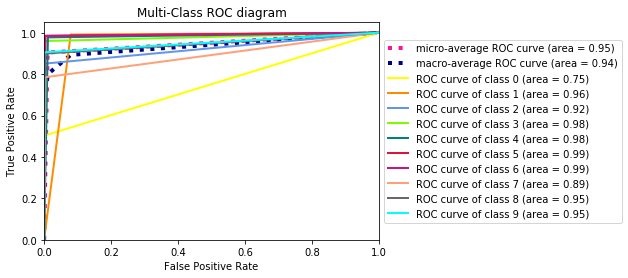

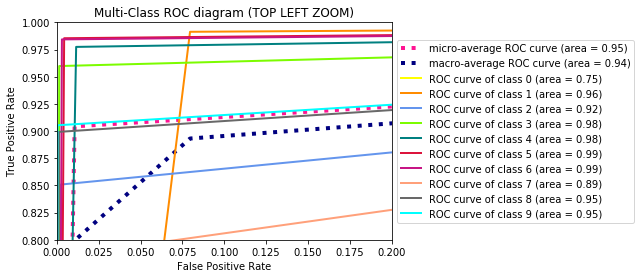

In [40]:
roc.plotROC(labels,pred)

In [41]:
test_acc = accuracy_score(labels, pred)

In [42]:
print("Test Accuarcy:{}".format(test_acc))
print("Training Accuaracy: {}".format(train_acc))
print("Difference: {}".format(train_acc - test_acc))

Test Accuarcy:0.9043264503441495
Training Accuaracy: 0.966966986656189
Difference: 0.06264053631203947


# Summarizing results - Altering training/test data sets

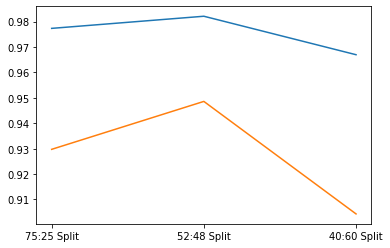

In [48]:
Test_Acc= [0.9297362110311751, 0.9485924112607099, 0.9043264503441495]
Train_Acc = [0.9773301482200623, 0.9821016192436218,0.966966986656189]
Data= ["75:25 Split","52:48 Split","40:60 Split"]

plt.plot(Data,Train_Acc,Data,Test_Acc)

# Experiments

In [109]:
def construct_new_model_Experment(i, j, k):
    model = Sequential()
    # Dense Adds fully connected nodes in each layer 

    # Input layer is the number of pixels & their values 

    # Layer 1
    model.add(Dense(i, activation = 'relu',input_shape=(784,)))

    # Layer 2
    model.add(Dense(i, activation = 'relu'))
    
    #Output Layer
    model.add(Dense(10, activation = 'softmax'))
  
    adam = keras.optimizers.Adam(learning_rate=j, beta_1=k, beta_2=0.999, amsgrad=False)
    
    model.compile(optimizer=adam, loss='categorical_crossentropy', metrics = ['accuracy'])
    
    return model

In [ ]:
# Ref:[https://www.youtube.com/watch?v=gJo0uNL-5Qw] - Used to make code more concise 
def run_experiment(model, x_train, x_test, y_train, y_test, y_train_main):
    x = model.fit(x_train, y_train, epochs = 20)
    
    print("------------------Experimantal Results Begin: NON = {} LR ={} M = {} ------------------".format(NON, LR, M))
    #print(model.summary())
    train_acc = x.history['accuracy'][-1]
    pred  = model.predict_classes(x_test)
    
    test_acc = accuracy_score(y_train_main, pred)
    
    print(classification_report(y_train_main, pred))
          
    roc.plotROC(y_train_main,pred)
    
    print("Test Accuarcy:{}".format(test_acc))
    print("Training Accuaracy: {}".format(train_acc))
    print("Difference: {}".format(train_acc - test_acc))
    print("------------------Experimantal Results End---------------")
    
    return (test_acc, train_acc)

# Neuron Experiment

In [121]:
Neurons =[256, 512, 1024, 2048, 3048]256, 512, 1024, 2048, 3048]

Epoch 1/20
12660/12660 [==============================] - 2s 129us/step - loss: 0.9101 - accuracy: 0.7210
Epoch 2/20
12660/12660 [==============================] - 2s 122us/step - loss: 0.3952 - accuracy: 0.8749
Epoch 3/20
12660/12660 [==============================] - 2s 124us/step - loss: 0.3041 - accuracy: 0.9019
Epoch 4/20
12660/12660 [==============================] - 2s 122us/step - loss: 0.2327 - accuracy: 0.9251
Epoch 5/20
12660/12660 [==============================] - 2s 124us/step - loss: 0.1863 - accuracy: 0.9420
Epoch 6/20
12660/12660 [==============================] - 2s 123us/step - loss: 0.1736 - accuracy: 0.9472
Epoch 7/20
12660/12660 [==============================] - 2s 124us/step - loss: 0.1409 - accuracy: 0.9558
Epoch 8/20
12660/12660 [==============================] - 2s 126us/step - loss: 0.1375 - accuracy: 0.9552
Epoch 9/20
12660/12660 [==============================] - 2s 122us/step - loss: 0.1197 - accuracy: 0.9641
Epoch 10/20
12660/12660 [=====================

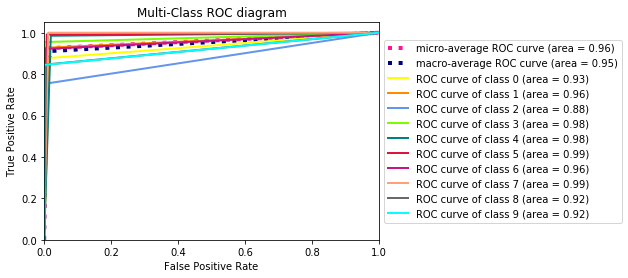

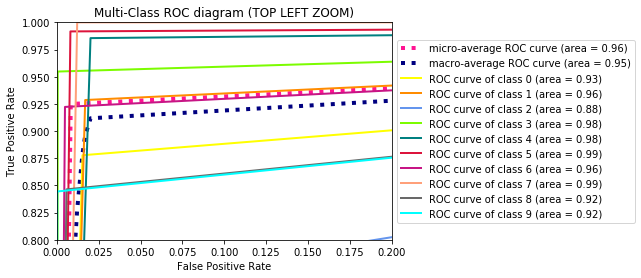

Test Accuarcy:0.9249400479616307
Training Accuaracy: 0.9846761226654053
Difference: 0.05973607470377462
------------------Experimantal Results End---------------
Epoch 1/20
12660/12660 [==============================] - 4s 296us/step - loss: 0.8509 - accuracy: 0.7289
Epoch 2/20
12660/12660 [==============================] - 3s 267us/step - loss: 0.3826 - accuracy: 0.8760
Epoch 3/20
12660/12660 [==============================] - 4s 311us/step - loss: 0.2747 - accuracy: 0.9121
Epoch 4/20
12660/12660 [==============================] - 3s 253us/step - loss: 0.2338 - accuracy: 0.9194
Epoch 5/20
12660/12660 [==============================] - 4s 282us/step - loss: 0.1893 - accuracy: 0.9356
Epoch 6/20
12660/12660 [==============================] - 4s 309us/step - loss: 0.1633 - accuracy: 0.9429
Epoch 7/20
12660/12660 [==============================] - 4s 353us/step - loss: 0.1502 - accuracy: 0.9517
Epoch 8/20
12660/12660 [==============================] - 5s 392us/step - loss: 0.1180 - accurac

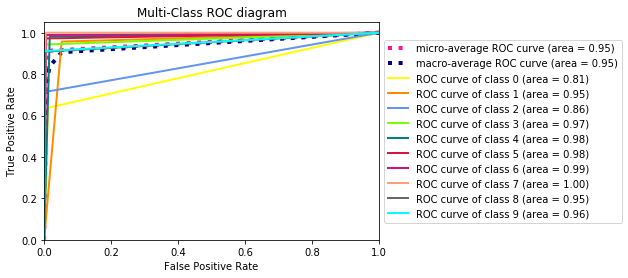

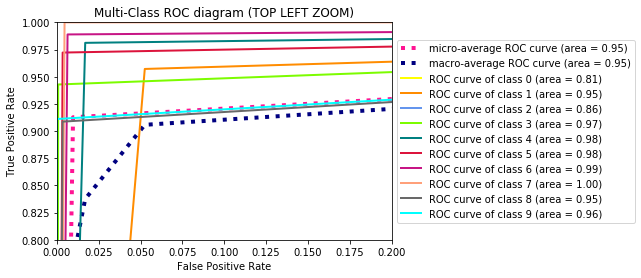

Test Accuarcy:0.9127098321342926
Training Accuaracy: 0.9860979318618774
Difference: 0.07338809972758487
------------------Experimantal Results End---------------
Epoch 1/20
12660/12660 [==============================] - 11s 895us/step - loss: 0.8604 - accuracy: 0.7243
Epoch 2/20
12660/12660 [==============================] - 10s 761us/step - loss: 0.3741 - accuracy: 0.8712
Epoch 3/20
12660/12660 [==============================] - 11s 845us/step - loss: 0.2707 - accuracy: 0.9088
Epoch 4/20
12660/12660 [==============================] - 10s 755us/step - loss: 0.2417 - accuracy: 0.9215
Epoch 5/20
12660/12660 [==============================] - 8s 671us/step - loss: 0.1748 - accuracy: 0.9415
Epoch 6/20
12660/12660 [==============================] - 9s 696us/step - loss: 0.1473 - accuracy: 0.9490
Epoch 7/20
12660/12660 [==============================] - 9s 687us/step - loss: 0.1519 - accuracy: 0.9487
Epoch 8/20
12660/12660 [==============================] - 9s 672us/step - loss: 0.1204 - acc

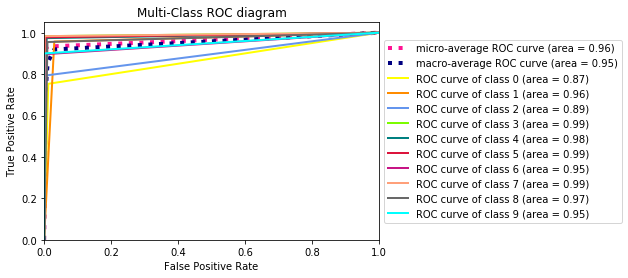

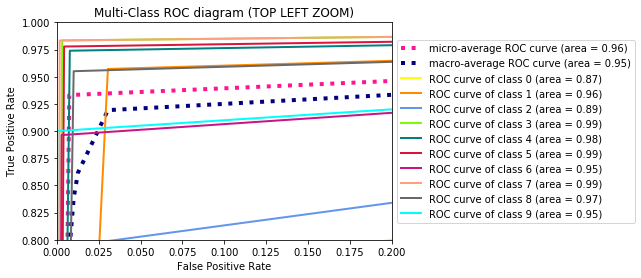

Test Accuarcy:0.9330935251798561
Training Accuaracy: 0.9821485280990601
Difference: 0.04905500291920395
------------------Experimantal Results End---------------
Epoch 1/20
12660/12660 [==============================] - 29s 2ms/step - loss: 0.8367 - accuracy: 0.7261
Epoch 2/20
12660/12660 [==============================] - 31s 2ms/step - loss: 0.3638 - accuracy: 0.8724
Epoch 3/20
12660/12660 [==============================] - 27s 2ms/step - loss: 0.2752 - accuracy: 0.9047
Epoch 4/20
12660/12660 [==============================] - 28s 2ms/step - loss: 0.2081 - accuracy: 0.9306
Epoch 5/20
12660/12660 [==============================] - 28s 2ms/step - loss: 0.1973 - accuracy: 0.9341
Epoch 6/20
12660/12660 [==============================] - 30s 2ms/step - loss: 0.1704 - accuracy: 0.9406
Epoch 7/20
12660/12660 [==============================] - 28s 2ms/step - loss: 0.1483 - accuracy: 0.9509
Epoch 8/20
12660/12660 [==============================] - 28s 2ms/step - loss: 0.1384 - accuracy: 0.953

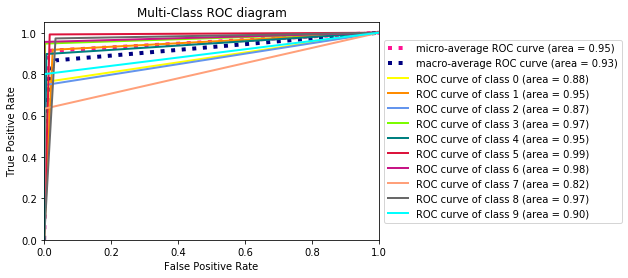

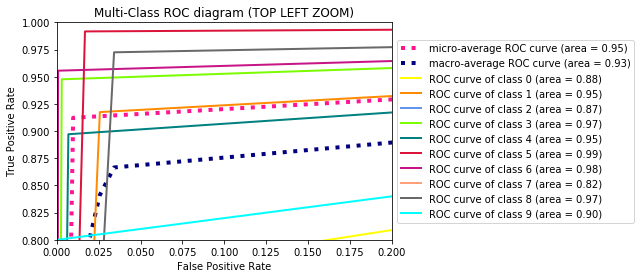

Test Accuarcy:0.9122302158273381
Training Accuaracy: 0.9769352078437805
Difference: 0.06470499201644242
------------------Experimantal Results End---------------
Epoch 1/20
12660/12660 [==============================] - 63s 5ms/step - loss: 0.8382 - accuracy: 0.7194
Epoch 2/20
12660/12660 [==============================] - 54s 4ms/step - loss: 0.3763 - accuracy: 0.8663
Epoch 3/20
12660/12660 [==============================] - 56s 4ms/step - loss: 0.2630 - accuracy: 0.9088
Epoch 4/20
12660/12660 [==============================] - 58s 5ms/step - loss: 0.2271 - accuracy: 0.9235
Epoch 5/20
12660/12660 [==============================] - 59s 5ms/step - loss: 0.1985 - accuracy: 0.9333
Epoch 6/20
12660/12660 [==============================] - 57s 4ms/step - loss: 0.1669 - accuracy: 0.9436
Epoch 7/20
12660/12660 [==============================] - 57s 5ms/step - loss: 0.1716 - accuracy: 0.9392
Epoch 8/20
12660/12660 [==============================] - 57s 4ms/step - loss: 0.1231 - accuracy: 0.960

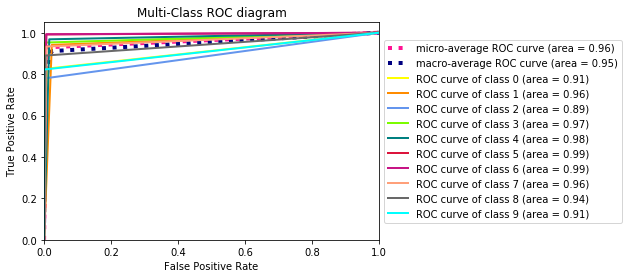

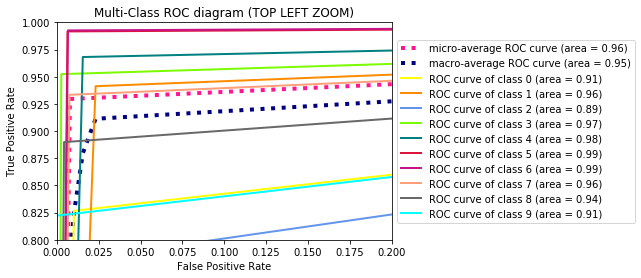

Test Accuarcy:0.9294964028776979
Training Accuaracy: 0.9733017086982727
Difference: 0.04380530582057485
------------------Experimantal Results End---------------


In [122]:

LR  = 0.001
M   = 0.9

Results = []

for NON in Neurons:
    Results.append(run_experiment(construct_new_model_Experment(NON, LR, M), x_train, x_test, y_train_Cat, y_test_Cat, y_test))

In [123]:
Results

[(0.9249400479616307, 0.9846761),
 (0.9127098321342926, 0.98609793),
 (0.9330935251798561, 0.9821485),
 (0.9122302158273381, 0.9769352),
 (0.9294964028776979, 0.9733017)]

In [124]:
Test = []
Train = []

for i in range(len(Results)):
    test, train = Results[i]
    Test.append(test)
    Train.append(train)

In [125]:
Test

[0.9249400479616307,
 0.9127098321342926,
 0.9330935251798561,
 0.9122302158273381,
 0.9294964028776979]

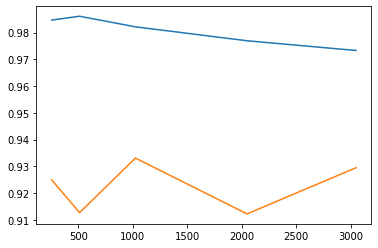

In [127]:
plt.plot( Neurons,Train, Neurons, Test)

# Learning Rate Experiment 

In [138]:
NON = 512
M   = 0.9
LRs =[0.001, 0.005, 0.010, 0.015, 0.020]

Epoch 1/20
12660/12660 [==============================] - 4s 277us/step - loss: 0.8276 - accuracy: 0.7359
Epoch 2/20
12660/12660 [==============================] - 3s 274us/step - loss: 0.3641 - accuracy: 0.8816
Epoch 3/20
12660/12660 [==============================] - 4s 281us/step - loss: 0.2892 - accuracy: 0.9081
Epoch 4/20
12660/12660 [==============================] - 3s 267us/step - loss: 0.2527 - accuracy: 0.9181
Epoch 5/20
12660/12660 [==============================] - 3s 271us/step - loss: 0.2086 - accuracy: 0.9330
Epoch 6/20
12660/12660 [==============================] - 3s 273us/step - loss: 0.1406 - accuracy: 0.9539
Epoch 7/20
12660/12660 [==============================] - 3s 271us/step - loss: 0.1496 - accuracy: 0.9512
Epoch 8/20
12660/12660 [==============================] - 3s 271us/step - loss: 0.1267 - accuracy: 0.9585
Epoch 9/20
12660/12660 [==============================] - 3s 269us/step - loss: 0.1255 - accuracy: 0.9562
Epoch 10/20
12660/12660 [=====================

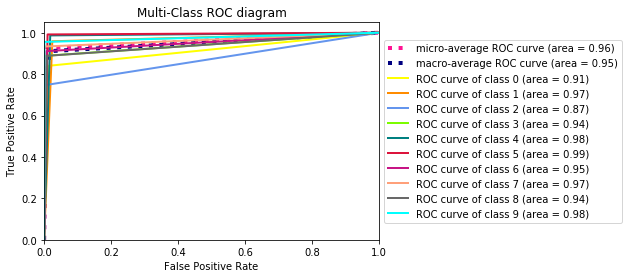

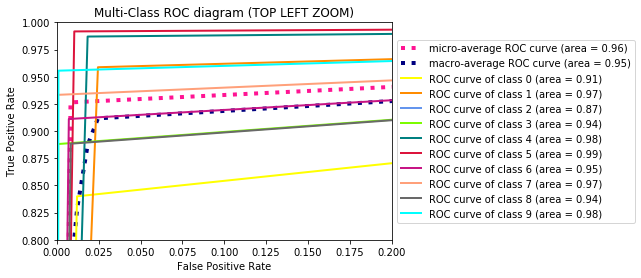

Test Accuarcy:0.926378896882494
Training Accuaracy: 0.9849920868873596
Difference: 0.058613190004865645
------------------Experimantal Results End---------------
Epoch 1/20
12660/12660 [==============================] - 3s 265us/step - loss: 0.9938 - accuracy: 0.6739
Epoch 2/20
12660/12660 [==============================] - 3s 263us/step - loss: 0.4160 - accuracy: 0.8463
Epoch 3/20
12660/12660 [==============================] - 3s 260us/step - loss: 0.3299 - accuracy: 0.8825
Epoch 4/20
12660/12660 [==============================] - 3s 260us/step - loss: 0.2660 - accuracy: 0.9061
Epoch 5/20
12660/12660 [==============================] - 4s 300us/step - loss: 0.2258 - accuracy: 0.9217
Epoch 6/20
12660/12660 [==============================] - 4s 297us/step - loss: 0.2083 - accuracy: 0.9263
Epoch 7/20
12660/12660 [==============================] - 3s 276us/step - loss: 0.1795 - accuracy: 0.9385
Epoch 8/20
12660/12660 [==============================] - 4s 295us/step - loss: 0.1927 - accurac

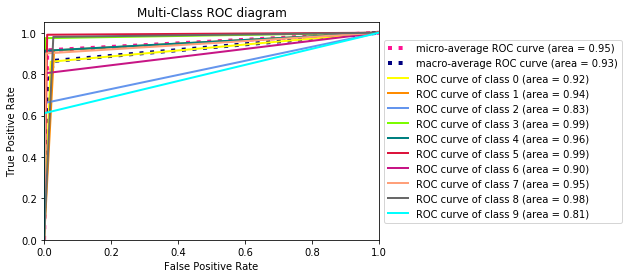

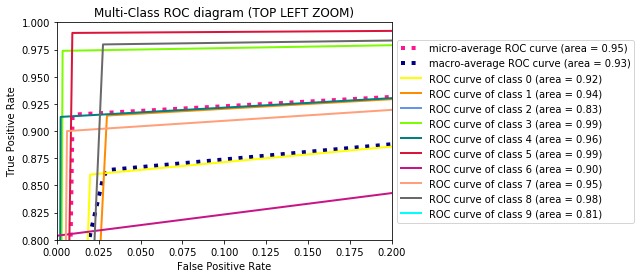

Test Accuarcy:0.9151079136690647
Training Accuaracy: 0.9609794616699219
Difference: 0.04587154800085713
------------------Experimantal Results End---------------
Epoch 1/20
12660/12660 [==============================] - 5s 391us/step - loss: 1.3401 - accuracy: 0.5300
Epoch 2/20
12660/12660 [==============================] - 4s 329us/step - loss: 0.7895 - accuracy: 0.7038
Epoch 3/20
12660/12660 [==============================] - 4s 309us/step - loss: 0.7182 - accuracy: 0.7320
Epoch 4/20
12660/12660 [==============================] - 4s 287us/step - loss: 0.6452 - accuracy: 0.7609
Epoch 5/20
12660/12660 [==============================] - 3s 263us/step - loss: 0.5703 - accuracy: 0.7828
Epoch 6/20
12660/12660 [==============================] - 3s 251us/step - loss: 0.5481 - accuracy: 0.8030
Epoch 7/20
12660/12660 [==============================] - 3s 251us/step - loss: 0.5224 - accuracy: 0.8079
Epoch 8/20
12660/12660 [==============================] - 3s 252us/step - loss: 0.4859 - accurac

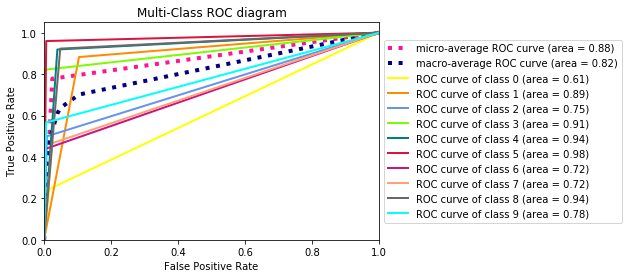

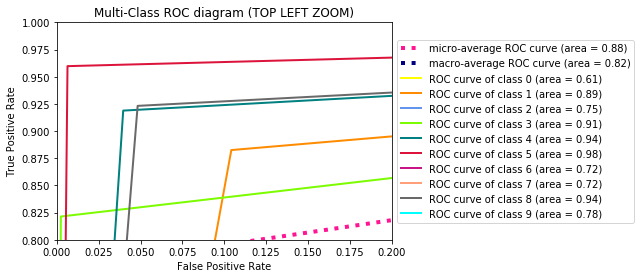

Test Accuarcy:0.7781774580335732
Training Accuaracy: 0.8706161379814148
Difference: 0.0924386799478416
------------------Experimantal Results End---------------
Epoch 1/20
12660/12660 [==============================] - 3s 270us/step - loss: 1.3386 - accuracy: 0.6006
Epoch 2/20
12660/12660 [==============================] - 4s 294us/step - loss: 0.7146 - accuracy: 0.7419
Epoch 3/20
12660/12660 [==============================] - 3s 261us/step - loss: 0.5981 - accuracy: 0.7802
Epoch 4/20
12660/12660 [==============================] - 3s 252us/step - loss: 0.5022 - accuracy: 0.8212
Epoch 5/20
12660/12660 [==============================] - 3s 252us/step - loss: 0.4677 - accuracy: 0.8363
Epoch 6/20
12660/12660 [==============================] - 3s 252us/step - loss: 0.4550 - accuracy: 0.8408
Epoch 7/20
12660/12660 [==============================] - 3s 251us/step - loss: 0.4360 - accuracy: 0.8511
Epoch 8/20
12660/12660 [==============================] - 3s 254us/step - loss: 0.4347 - accuracy

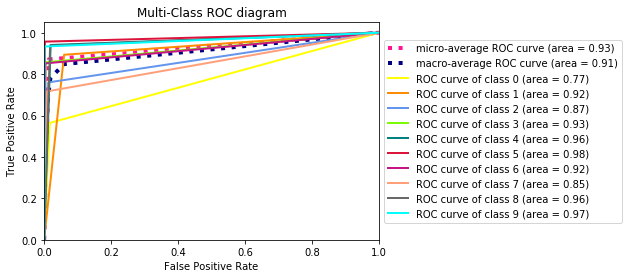

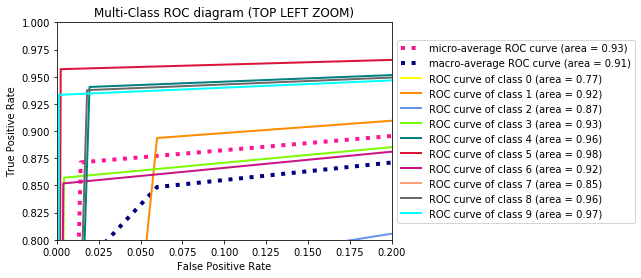

Test Accuarcy:0.8712230215827338
Training Accuaracy: 0.8961295485496521
Difference: 0.024906526966918308
------------------Experimantal Results End---------------
Epoch 1/20
12660/12660 [==============================] - 4s 287us/step - loss: 2.3769 - accuracy: 0.2276
Epoch 2/20
12660/12660 [==============================] - 3s 265us/step - loss: 1.6631 - accuracy: 0.3536
Epoch 3/20
12660/12660 [==============================] - 3s 273us/step - loss: 1.5250 - accuracy: 0.3962
Epoch 4/20
12660/12660 [==============================] - 3s 271us/step - loss: 1.4239 - accuracy: 0.4270
Epoch 5/20
12660/12660 [==============================] - 3s 268us/step - loss: 1.4558 - accuracy: 0.4254
Epoch 6/20
12660/12660 [==============================] - 3s 271us/step - loss: 1.4068 - accuracy: 0.4396
Epoch 7/20
12660/12660 [==============================] - 3s 258us/step - loss: 1.3717 - accuracy: 0.4474
Epoch 8/20
12660/12660 [==============================] - 3s 257us/step - loss: 1.3694 - accura

/home/andy/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

         0.0       0.30      0.03      0.05       450
         1.0       0.28      0.15      0.20       630
         2.0       0.00      0.00      0.00       150
         3.0       0.00      0.00      0.00       420
         4.0       0.32      0.97      0.48       690
         5.0       0.57      0.94      0.71       720
         6.0       0.00      0.00      0.00       270
         7.0       0.00      0.00      0.00        60
         8.0       0.54      0.40      0.46       690
         9.0       0.00      0.00      0.00        90

    accuracy                           0.42      4170
   macro avg       0.20      0.25      0.19      4170
weighted avg       0.32      0.42      0.31      4170



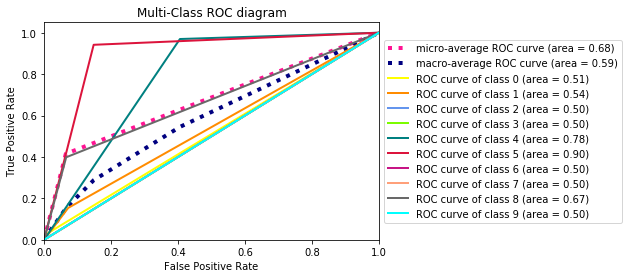

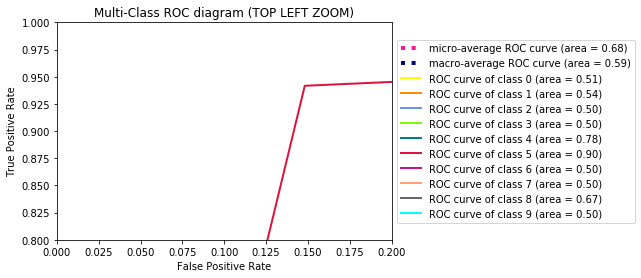

Test Accuarcy:0.415347721822542
Training Accuaracy: 0.4507898986339569
Difference: 0.03544217681141493
------------------Experimantal Results End---------------


In [139]:
Results2 = []

for LR in LRs:
    Results2.append(run_experiment(construct_new_model_Experment(NON, LR, M), x_train, x_test, y_train_Cat, y_test_Cat, y_test))

In [140]:
Test2 = []
Train2 = []

for i in range(len(Results2)):
    test, train = Results2[i]
    Test2.append(test)
    Train2.append(train)

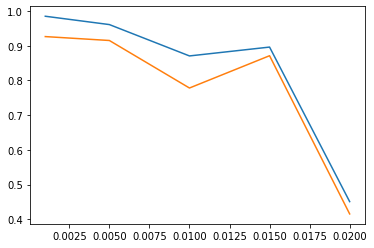

In [141]:
plt.plot( LRs,Train2, LRs, Test2)

# (adam) Momentum Experiment

In [156]:
NON = 512
Ms   = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
LR = 0.001

Epoch 1/20
12660/12660 [==============================] - 4s 278us/step - loss: 0.8906 - accuracy: 0.7130
Epoch 2/20
12660/12660 [==============================] - 3s 273us/step - loss: 0.4015 - accuracy: 0.8654
Epoch 3/20
12660/12660 [==============================] - 3s 274us/step - loss: 0.2984 - accuracy: 0.8990
Epoch 4/20
12660/12660 [==============================] - 4s 303us/step - loss: 0.2827 - accuracy: 0.9094
Epoch 5/20
12660/12660 [==============================] - 4s 288us/step - loss: 0.1967 - accuracy: 0.9342
Epoch 6/20
12660/12660 [==============================] - 4s 282us/step - loss: 0.1761 - accuracy: 0.9404
Epoch 7/20
12660/12660 [==============================] - 4s 296us/step - loss: 0.1466 - accuracy: 0.9517
Epoch 8/20
12660/12660 [==============================] - 4s 295us/step - loss: 0.1734 - accuracy: 0.9447
Epoch 9/20
12660/12660 [==============================] - 3s 270us/step - loss: 0.1278 - accuracy: 0.9563
Epoch 10/20
12660/12660 [=====================

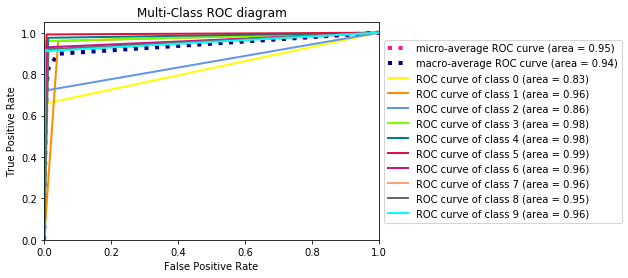

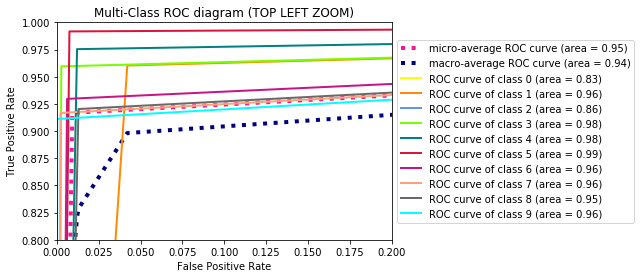

Test Accuarcy:0.9167865707434053
Training Accuaracy: 0.9732227325439453
Difference: 0.05643616180054001
------------------Experimantal Results End---------------
Epoch 1/20
12660/12660 [==============================] - 5s 421us/step - loss: 0.8881 - accuracy: 0.7103
Epoch 2/20
12660/12660 [==============================] - 4s 349us/step - loss: 0.3899 - accuracy: 0.8724
Epoch 3/20
12660/12660 [==============================] - 3s 248us/step - loss: 0.2979 - accuracy: 0.9010
Epoch 4/20
12660/12660 [==============================] - 3s 256us/step - loss: 0.2382 - accuracy: 0.9251
Epoch 5/20
12660/12660 [==============================] - 3s 256us/step - loss: 0.2020 - accuracy: 0.9360
Epoch 6/20
12660/12660 [==============================] - 3s 255us/step - loss: 0.1509 - accuracy: 0.9474
Epoch 7/20
12660/12660 [==============================] - 3s 254us/step - loss: 0.1494 - accuracy: 0.9497
Epoch 8/20
12660/12660 [==============================] - 3s 255us/step - loss: 0.1328 - accurac

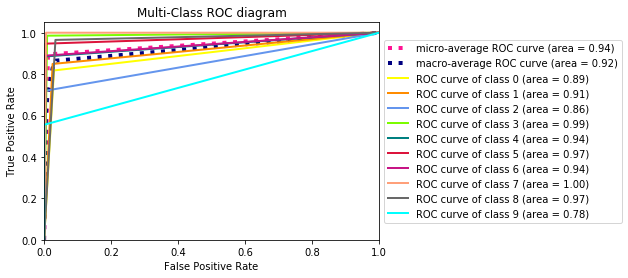

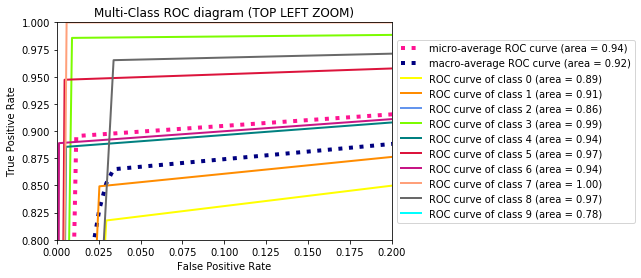

Test Accuarcy:0.8954436450839328
Training Accuaracy: 0.9798578023910522
Difference: 0.08441415730711943
------------------Experimantal Results End---------------
Epoch 1/20
12660/12660 [==============================] - 4s 291us/step - loss: 0.8703 - accuracy: 0.7211
Epoch 2/20
12660/12660 [==============================] - 3s 263us/step - loss: 0.3825 - accuracy: 0.8742
Epoch 3/20
12660/12660 [==============================] - 3s 256us/step - loss: 0.2789 - accuracy: 0.9036
Epoch 4/20
12660/12660 [==============================] - 3s 256us/step - loss: 0.2254 - accuracy: 0.9227
Epoch 5/20
12660/12660 [==============================] - 3s 254us/step - loss: 0.1979 - accuracy: 0.9331
Epoch 6/20
12660/12660 [==============================] - 3s 255us/step - loss: 0.1709 - accuracy: 0.9433
Epoch 7/20
12660/12660 [==============================] - 3s 255us/step - loss: 0.1536 - accuracy: 0.9476
Epoch 8/20
12660/12660 [==============================] - 3s 255us/step - loss: 0.1385 - accurac

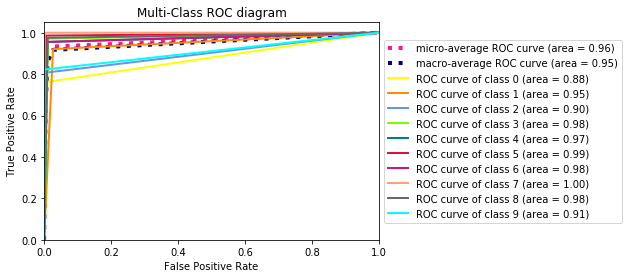

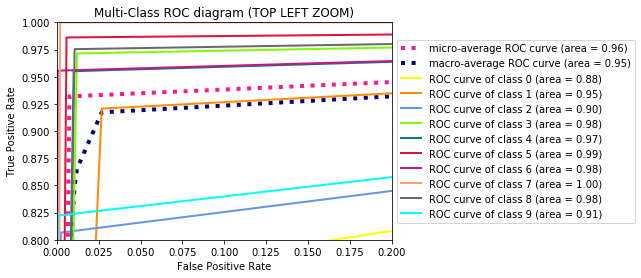

Test Accuarcy:0.93189448441247
Training Accuaracy: 0.9777251482009888
Difference: 0.045830663788518744
------------------Experimantal Results End---------------
Epoch 1/20
12660/12660 [==============================] - 3s 265us/step - loss: 0.8507 - accuracy: 0.7211
Epoch 2/20
12660/12660 [==============================] - 3s 253us/step - loss: 0.3890 - accuracy: 0.8709
Epoch 3/20
12660/12660 [==============================] - 4s 289us/step - loss: 0.2789 - accuracy: 0.9083
Epoch 4/20
12660/12660 [==============================] - 4s 300us/step - loss: 0.2399 - accuracy: 0.9218
Epoch 5/20
12660/12660 [==============================] - 4s 334us/step - loss: 0.1905 - accuracy: 0.9393
Epoch 6/20
12660/12660 [==============================] - 4s 328us/step - loss: 0.1541 - accuracy: 0.9510
Epoch 7/20
12660/12660 [==============================] - 4s 294us/step - loss: 0.1424 - accuracy: 0.9533
Epoch 8/20
12660/12660 [==============================] - 4s 325us/step - loss: 0.1302 - accuracy

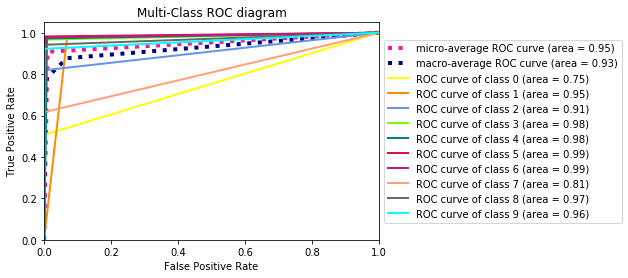

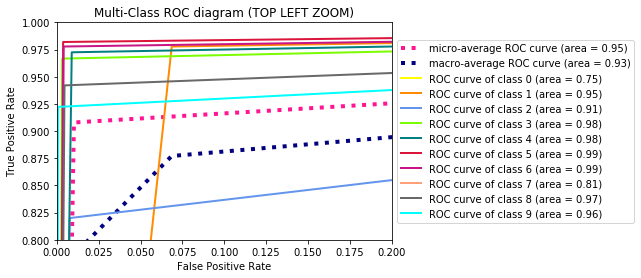

Test Accuarcy:0.9079136690647482
Training Accuaracy: 0.9842022061347961
Difference: 0.0762885370700479
------------------Experimantal Results End---------------
Epoch 1/20
12660/12660 [==============================] - 3s 264us/step - loss: 0.8326 - accuracy: 0.7400
Epoch 2/20
12660/12660 [==============================] - 4s 302us/step - loss: 0.3694 - accuracy: 0.8807
Epoch 3/20
12660/12660 [==============================] - 4s 340us/step - loss: 0.2908 - accuracy: 0.9034
Epoch 4/20
12660/12660 [==============================] - 4s 325us/step - loss: 0.2213 - accuracy: 0.9277
Epoch 5/20
12660/12660 [==============================] - 4s 329us/step - loss: 0.1942 - accuracy: 0.9370
Epoch 6/20
12660/12660 [==============================] - 4s 351us/step - loss: 0.1693 - accuracy: 0.9464
Epoch 7/20
12660/12660 [==============================] - 4s 307us/step - loss: 0.1442 - accuracy: 0.9521
Epoch 8/20
12660/12660 [==============================] - 4s 325us/step - loss: 0.1321 - accuracy

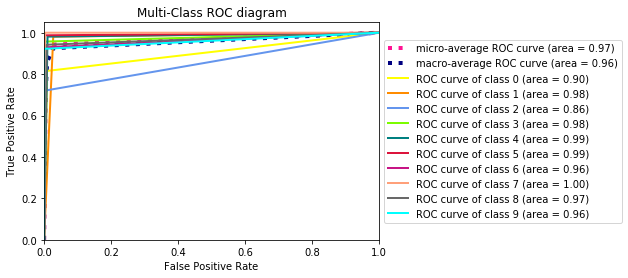

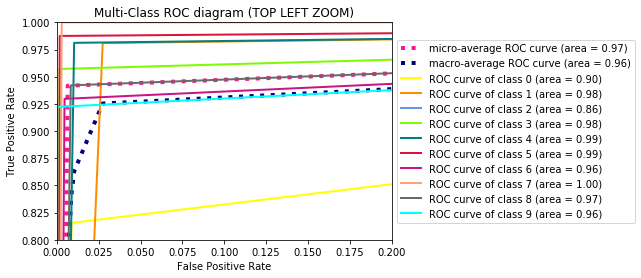

Test Accuarcy:0.9417266187050359
Training Accuaracy: 0.9804107546806335
Difference: 0.03868413597559761
------------------Experimantal Results End---------------
Epoch 1/20
12660/12660 [==============================] - 4s 313us/step - loss: nan - accuracy: 0.1114
Epoch 2/20
12660/12660 [==============================] - 4s 303us/step - loss: nan - accuracy: 0.1114
Epoch 3/20
12660/12660 [==============================] - 4s 300us/step - loss: nan - accuracy: 0.1114
Epoch 4/20
12660/12660 [==============================] - 4s 304us/step - loss: nan - accuracy: 0.1114
Epoch 5/20
12660/12660 [==============================] - 4s 300us/step - loss: nan - accuracy: 0.1114
Epoch 6/20
12660/12660 [==============================] - 4s 302us/step - loss: nan - accuracy: 0.1114
Epoch 7/20
12660/12660 [==============================] - 4s 301us/step - loss: nan - accuracy: 0.1114
Epoch 8/20
12660/12660 [==============================] - 4s 299us/step - loss: nan - accuracy: 0.1114
Epoch 9/20
126

/home/andy/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

         0.0       0.11      1.00      0.19       450
         1.0       0.00      0.00      0.00       630
         2.0       0.00      0.00      0.00       150
         3.0       0.00      0.00      0.00       420
         4.0       0.00      0.00      0.00       690
         5.0       0.00      0.00      0.00       720
         6.0       0.00      0.00      0.00       270
         7.0       0.00      0.00      0.00        60
         8.0       0.00      0.00      0.00       690
         9.0       0.00      0.00      0.00        90

    accuracy                           0.11      4170
   macro avg       0.01      0.10      0.02      4170
weighted avg       0.01      0.11      0.02      4170



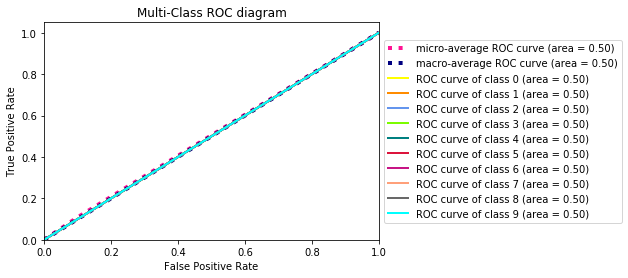

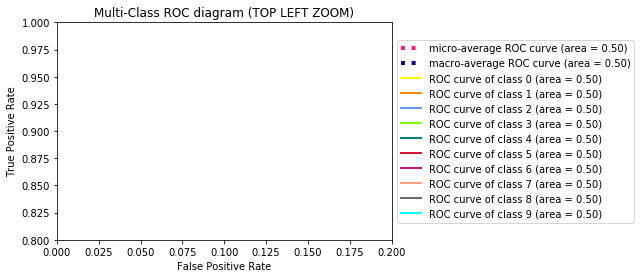

Test Accuarcy:0.1079136690647482
Training Accuaracy: 0.11137440800666809
Difference: 0.003460738941919894
------------------Experimantal Results End---------------


In [157]:
Results3 = []

for M in Ms:
    Results3.append(run_experiment(construct_new_model_Experment(NON, LR, M), x_train, x_test, y_train_Cat, y_test_Cat, y_test))

In [158]:
Test3 = []
Train3 = []

for i in range(len(Results3)):
    test, train = Results3[i]
    Test3.append(test)
    Train3.append(train)

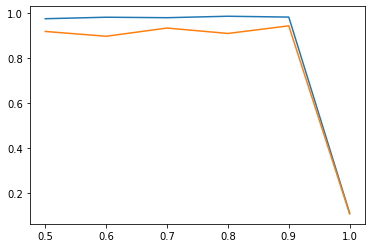

In [159]:
plt.plot( Ms,Train3, Ms, Test3)

In [155]:
print(Test3)
print(Train3)

[0.16546762589928057, 0.16546762589928057, 0.16546762589928057, 0.17266187050359713, 0.30455635491606714, 0.1079136690647482]
[0.16484992, 0.16761453, 0.16532385, 0.16911532, 0.48949447, 0.11137441]
